In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt

In [125]:
# Read in hourly normalized valuation data.
profiles = pd.read_csv('output/Norm_Val_by_Config.csv')

How do we describe the spatial and temporal variation in the value created per kW of solar PV capacity over the course of an hour under different tariff structures? For each region (in this case, utility service territories), calculate the difference between the value that's created under a time-of-use rate (as is the case for NEM 2.0) and that which would be created if the owners of distributed generation were to instead receive the location marginal price at the nearest grid node for electricity they do not consume immediately on-site. Then, display this difference for each hour of the year as a heat map.

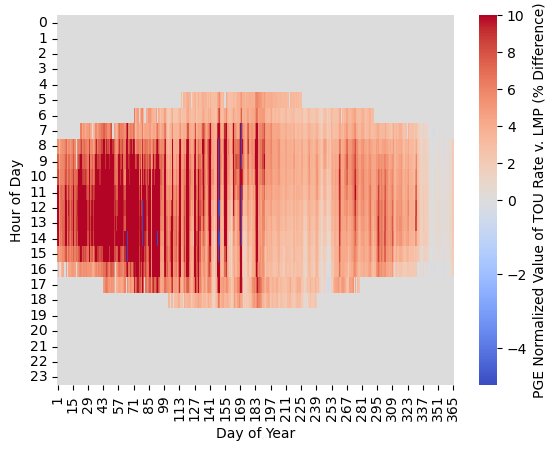

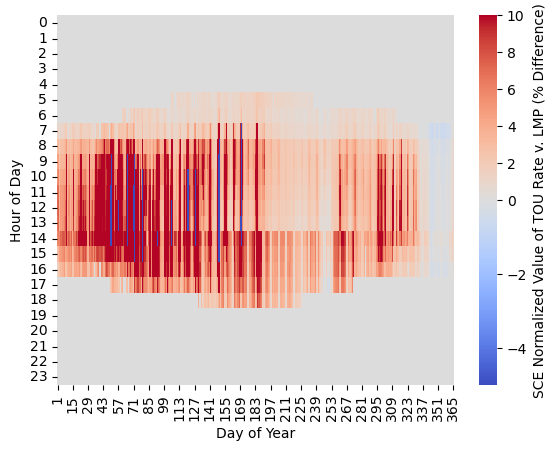

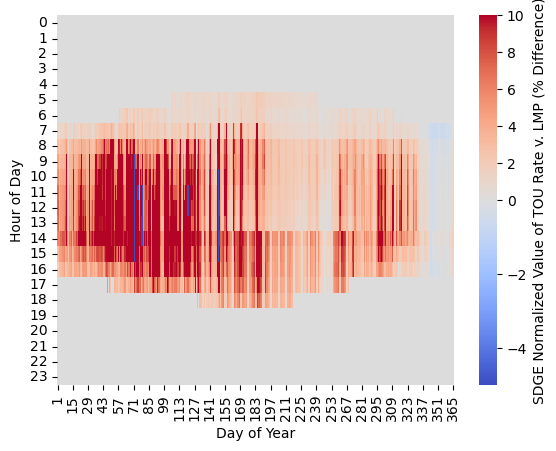

In [182]:
# Set up heat map. 
profiles['Day of Year'] = pd.to_datetime(profiles['Timestamp'], format='%Y-%m-%d %H:%M:%S').dt.dayofyear
profiles['Hour of Day'] = pd.to_datetime(profiles['Timestamp'], format='%Y-%m-%d %H:%M:%S').dt.hour

# For each utility...
for utility in ['PGE', 'SCE', 'SDGE']:

    # Column name. 
    name = f'{utility} Normalized Value of TOU Rate v. LMP (% Difference)'

    # Fill NaNs with zeros. 
    profiles[name].fillna(0, inplace=True)

    # Replace infinity with zeros.
    profiles[name].replace(to_replace=np.inf, value=100, inplace=True)

    # Plot percentage difference betwen TOU and LMP valuation for each hour of the year. 
    pivot = profiles.pivot(index='Hour of Day', columns='Day of Year', values=name)
    divnorm=colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=10)
    map = sns.heatmap(pivot, cbar_kws={'label': name}, cmap='coolwarm', norm=divnorm)
    plt.show()

What this illustrates is how distributed generation is valued differently under the NEM 2.0 policy versus a tariff structure that employs locational marginal prices (LMP). Where the heat map is grey, the owner of rooftop solar would earn the same amount (per kW of system capacity) under NEM 2.0 as they would under a tariff that compensated them for excess generation at a rate equal to the LMP at the closest grid node when the generation occured. Most of the grey appears at night because solar panels don't generate any value when the sun is down regardless of the tariff. However, where the map is red, each kW of capacity generates more value under the NEM 2.0 policy than it would under LMPs. The opposite is true for blue. 

How should we interpret these results? If we believe that LMPs are a reasonable estimate of the true marginal benefit that distributed generation provides to the grid (which we argued above), then the balance of red and blue illustrates how much we are currently over- or undervaluing rooftop solar, respectively. As is clear from the heat maps, we tend to overvalue distributed generation far more often than we undervalue it. The heat maps do reveal some variation in this trend throughout the year, with rooftop solar being more overvalued in the winter than in the summer, presumably because LMPs tend to be lower during the winter in California, where peak system demand is driven by air conditioning usage.

Interestingly, the heat maps also reveal that differences in the value of distributed generation between tariffs are more a function of time than location, suggesting it's more important to shift to more granular time-of-use rates than it is to differentiate rates based on location. This makes sense because although LMPs do vary between locations on the grid, they vary much more over the course of the year (or even a day). 

In [104]:
# Read in annual site valuation data.
df = pd.read_csv('output/Annual_Site_Vals.csv')

In [105]:
df.describe(include='all')

,Utility,NEM Tariff,System Size AC,Normalized Annual Value - NEM,Normalized Annual Value - LMP,Annual Value - NEM,Annual Value - LMP
count,1500393,1.500393e+06,1.500393e+06,1.500393e+06,1.500393e+06,1.500393e+06,1.500393e+06
unique,3,NaN,NaN,NaN,NaN,NaN,NaN
top,PGE,NaN,NaN,NaN,NaN,NaN,NaN
freq,700084,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.642279e+00,6.033560e+00,5.262168e+02,1.036079e+02,3.166924e+03,6.256080e+02
std,NaN,4.793296e-01,5.141241e+00,1.110112e+02,4.748729e+00,2.665370e+03,5.285440e+02
min,NaN,1.000000e+00,2.000000e-03,4.086583e+02,9.747592e+01,1.181219e+00,2.171896e-01
25%,NaN,1.000000e+00,3.779000e+00,4.098111e+02,1.000884e+02,1.876115e+03,3.883441e+02
50%,NaN,2.000000e+00,5.320000e+00,5.906093e+02,1.000884e+02,2.737898e+03,5.504862e+02
75%,NaN,2.000000e+00,7.459000e+00,5.906093e+02,1.085948e+02,3.947633e+03,7.734120e+02


Has investment in solar historically been misallocated?
1) Where have investments been concentrated?
2) What is the average annual value of sites in this region under NEM?
3) What is the true average annual value of these sites under LMPs?
4) Does this suggest investments should have been focused elsewhere?

In [106]:
# There is more solar capacity per customer in PGE's territory than elsewhere.
customers = {'PGE': 5480000, 'SCE': 5070000, 'SDGE': 3700000}
grouped = df[['Utility', 'Customers', 'System Size AC', ]].groupby('Utility', as_index=False).agg({'Customers': 'first', 'System Size AC': 'sum'})
grouped['Customers'] = grouped['Utility'].map(customers)
grouped['kW per Customer'] = grouped['System Size AC'] / grouped['Customers']
grouped

,Customers,System Size AC,kW per Customer
Utility,,,
PGE,5480000,4.295295e+06,0.783813
SCE,5070000,3.245091e+06,0.640057
SDGE,3700000,1.512325e+06,0.408737


In [122]:
# This makes sense because the average annual value of systems in the PGE territory 
# is significantly higher than elsewhere under NEM.
grouped = df[['Utility', 'Annual Value - NEM', ]].groupby('Utility', as_index=False).mean()
aav_nem_pge = grouped.loc[grouped['Utility'] == 'PGE', 'Annual Value - NEM'][0]
grouped['Percentage Diff from PGE'] = (grouped['Annual Value - NEM'] - aav_nem_pge)/aav_nem_pge
grouped


,Utility,Annual Value - NEM,Percentage Diff from PGE
0,PGE,3702.137013,0.000000
1,SCE,2536.504228,-0.314854
2,SDGE,3039.321498,-0.179036


In [123]:
# However, the difference in average annual value between PGE and SCE is much smaller when 
# LMPs are used for compensation. 
grouped = df[['Utility', 'Annual Value - LMP', ]].groupby('Utility', as_index=False).mean()
aav_lmp_pge = grouped.loc[grouped['Utility'] == 'PGE', 'Annual Value - LMP'][0]
grouped['Percentage Diff from PGE'] = (grouped['Annual Value - LMP'] - aav_lmp_pge)/aav_lmp_pge
grouped

,Utility,Annual Value - LMP,Percentage Diff from PGE
0,PGE,666.272359,0.000000
1,SCE,599.153923,-0.100737
2,SDGE,570.894827,-0.143151


In [108]:
# Average normalized annual value ($/kWcap/year) for systems on a flat rate.
anav_1_flat = df.loc[df['NEM Tariff'] == 1.0, 'Normalized Annual Value - NEM'].mean()
anav_1_flat

568.8316463047317

In [109]:
# Average normalized annual value ($/kWcap/year) if these systems switched to TOU rate.
anav_1_tou = df.loc[df['NEM Tariff'] == 1.0, 'Normalized Annual Value - NEM'].mean()
anav_1_tou

568.8316463047317

In [110]:
# Percent change in average normalized annual value of switching NEM 1.0 systems to NEM 2.0.
(anav_1_tou - anav_1_flat)/(anav_1_flat)

0.0

In [111]:
# Average normalized annual value ($/kWcap/year) for all systems on an NEM rate.
anav_nem = df['Normalized Annual Value - NEM'].mean()
anav_nem

526.2168476175017

In [112]:
# Average normalized annual value ($/kWcap/year) for all systems on an NEM rate.
anav_lmp = df['Normalized Annual Value - LMP'].mean()
anav_lmp

103.60786886249477

In [113]:
# Percent change in average normalized annual value of switching from systems from current rate to LMPs.
(anav_lmp - anav_nem)/(anav_nem)

-0.8031080355340396

In [114]:
# How much would the average annual value ($/year) change if all customers switched from current rate to LMPs?
aav_nem = df['Annual Value - NEM'].mean()
print(aav_nem)
aav_lmp = df['Annual Value - LMP'].mean()
print(aav_lmp)

(aav_lmp - aav_nem)/(aav_nem)

3166.923946005958
625.6080159498489


-0.8024556236221431

In [115]:
df['System Size AC'].mean()

6.033560301952928